# Introdução A computação Visual - Trabalho Prático 3
## Luiz Henrique De Melo Santos
## Otávio Augusto Silva

In [1]:
import os
import cv2
import tqdm
import numpy
import seaborn
import tensorflow
from matplotlib import pyplot
from tensorflow.keras import activations, callbacks, initializers, layers, losses, metrics, models, optimizers, utils

In [2]:
devices = tensorflow.config.list_physical_devices()
try:
    tensorflow.config.experimental.set_memory_growth(devices[1], True)
except:
    print(f"Error when enabling memory growth for device {devices[1]}")

In [3]:
VOCAB = "0123456789ABCDEFGHIJKLMNOPQRSTUVXWYZ"

In [4]:
labels = {}
for filename in os.listdir(os.path.join("CAPTCHA-10k", "labels10k")):
    with open(os.path.join("CAPTCHA-10k", "labels10k", filename), "r") as file:
        line = file.readlines()[0].rstrip('\n')
        if "?" not in line and len(line) == 6:
            labels[filename.split('.')[0]] = line.replace('\n', '')

In [5]:
vocab_mapping = {i: idx for idx, i in enumerate(VOCAB)}

In [6]:
classes = {}
for key in labels:
    classes[key] = [vocab_mapping[c] for c in labels[key]]

In [7]:
def train_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "treinamento")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "treinamento", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.split(image, 6, axis=1)
            yield (X, y)

In [8]:
def validation_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "validacao")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "validacao", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.array(numpy.split(image, 6, axis=1))
            yield (X, y)

In [9]:
def test_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "teste")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "teste", filename))
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            yield (image, y)

In [10]:
train_dataset = tensorflow.data.Dataset.from_generator(train_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [14]:
validation_dataset = tensorflow.data.Dataset.from_generator(validation_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [15]:
test_dataset = tensorflow.data.Dataset.from_generator(test_generator, (tensorflow.dtypes.uint8, tensorflow.dtypes.uint8), output_shapes=(tensorflow.TensorShape(((50, 180, 3))), tensorflow.TensorShape((6, 36))))

In [16]:
def create_model(shape: tuple) -> models.Model:
    inputs = tensorflow.keras.Input(shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", bias_initializer=initializers.Ones())(inputs)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", bias_initializer=initializers.Ones())(x)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation=activations.linear, bias_initializer=initializers.Ones())(x)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activations.linear, bias_initializer=initializers.Ones())(x)
    x = layers.PReLU(alpha_initializer=initializers.GlorotUniform())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(VOCAB), activation=activations.softmax, bias_initializer=tensorflow.ones)(x)
    return models.Model(inputs=inputs, outputs=outputs)

In [17]:
model = create_model((50, 30, 3))

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 30, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 30, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 50, 30, 32)        48000     
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 30, 64)        18496     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 50, 30, 64)        96000     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 30, 64)        256   

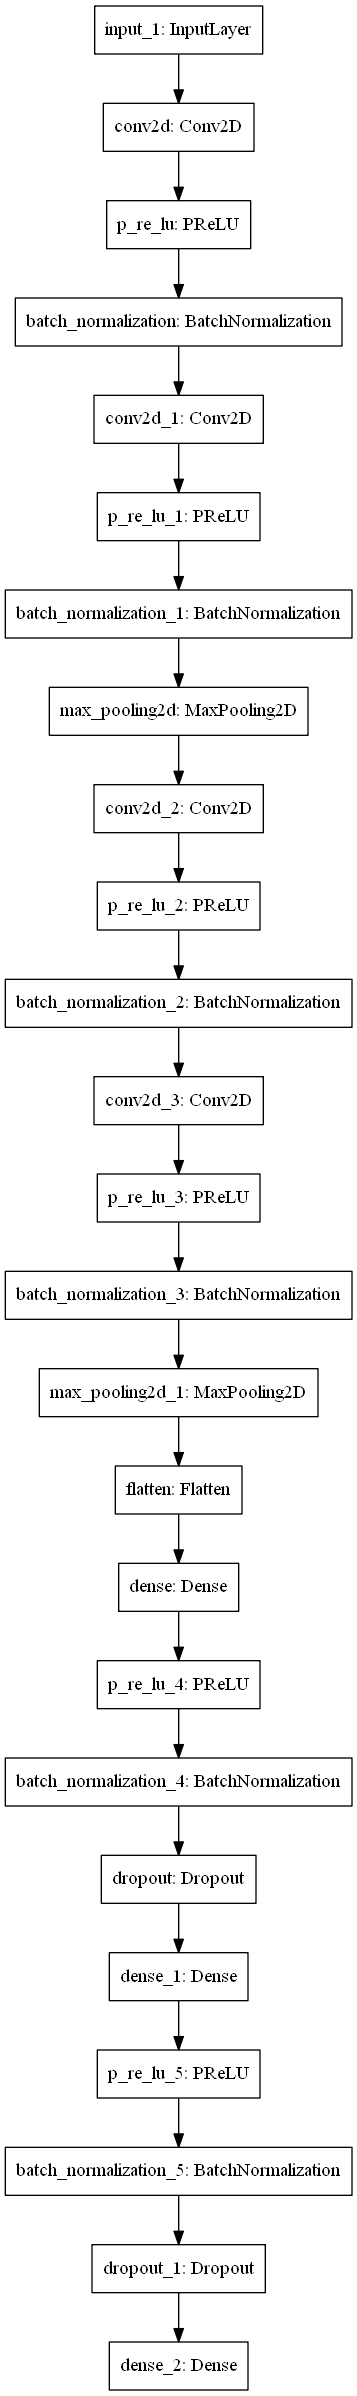

In [16]:
utils.plot_model(model)

In [19]:
model.compile(optimizer=optimizers.Adam(), loss=losses.CategoricalCrossentropy(), metrics=[metrics.CategoricalAccuracy()])

In [20]:
if not os.path.exists("log"):
    os.makedirs("log")
tensorboard_callback = callbacks.TensorBoard(log_dir="log", histogram_freq=1, write_images=True)

In [21]:
history = model.fit(train_dataset.batch(512), validation_data=validation_dataset.batch(512), epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
93/93 [==============================] - 38s 408ms/step - loss: 1.5005 - categorical_accuracy: 0.5757 - val_loss: 4.0561 - val_categorical_accuracy: 0.0801
Epoch 2/10
93/93 [==============================] - 29s 310ms/step - loss: 0.4708 - categorical_accuracy: 0.8596 - val_loss: 1.8696 - val_categorical_accuracy: 0.4868
Epoch 3/10
93/93 [==============================] - 30s 322ms/step - loss: 0.3088 - categorical_accuracy: 0.9073 - val_loss: 0.6997 - val_categorical_accuracy: 0.8150
Epoch 4/10
93/93 [==============================] - 30s 322ms/step - loss: 0.2371 - categorical_accuracy: 0.9284 - val_loss: 0.4348 - val_categorical_accuracy: 0.8714
Epoch 5/10
93/93 [==============================] - 29s 313ms/step - loss: 0.2004 - categorical_accuracy: 0.9362 - val_loss: 0.3403 - val_categorical_accuracy: 0.8979
Epoch 6/10
93/93 [==============================] - 29s 313ms/step - loss: 0.1683 - categorical_accuracy: 0.9469 - val_loss: 0.2331 - val_categorical_accuracy: 0.922

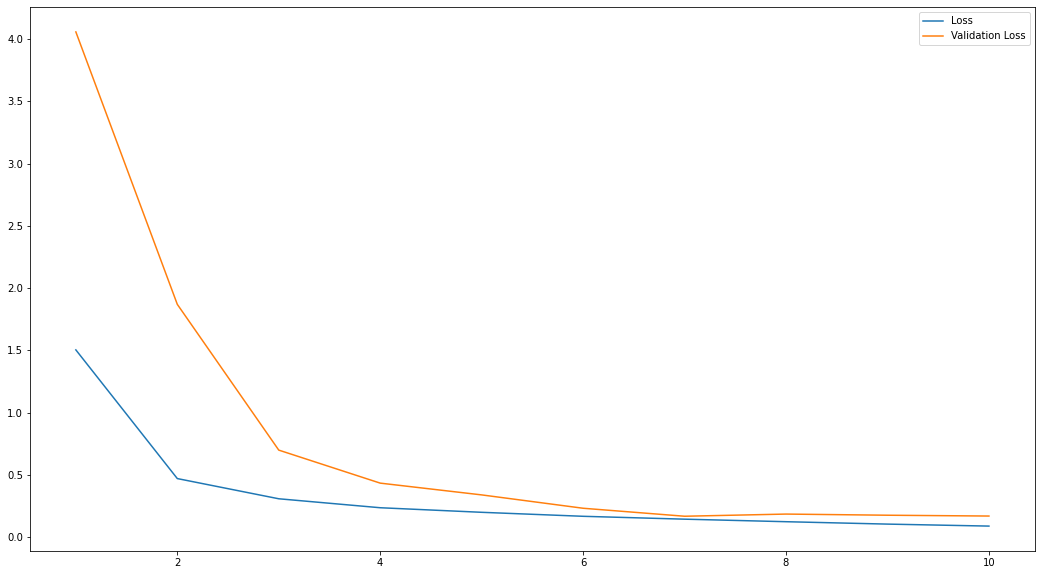

In [22]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["loss"], label="Loss")
seaborn.lineplot(x=range(1, 11), y=history.history["val_loss"], label="Validation Loss")
pyplot.show()

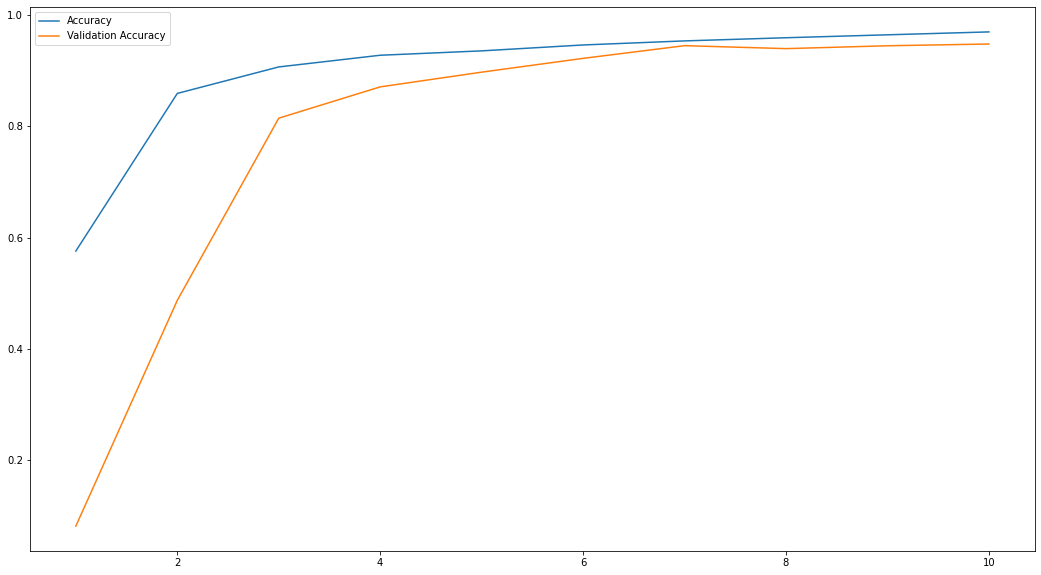

In [23]:
pyplot.figure(figsize=(18, 10))
seaborn.lineplot(x=range(1, 11), y=history.history["categorical_accuracy"], label="Accuracy")
seaborn.lineplot(x=range(1, 11), y=history.history["val_categorical_accuracy"], label="Validation Accuracy")
pyplot.show()

In [32]:
def predict(dataset: tensorflow.data.Dataset):
    with open("predictions.txt", "w") as file, tqdm.tqdm(total=len(list(dataset))) as pbar:
        j, k = 0, 0
        cc = losses.CategoricalCrossentropy()
        l = []
        for item, label in dataset:
            X = tensorflow.convert_to_tensor(tensorflow.split(item, 6, axis=1)) / 255
            #print(X.shape)
            p = model.predict(X)
            #print(p.shape)
            loss = cc(label, p)
            l.append(loss)
            pbar.update(1)
            j += 1
            if j % 10 == 0:
                pbar.set_description_str(f"Loss: {loss.numpy()}")
            s_true, s_pred = "", ""
            for i in range(label.shape[0]):
                idx = tensorflow.argmax(label[i])
                s_true += VOCAB[idx.numpy()]
                idx = tensorflow.argmax(p[i])
                s_pred += VOCAB[idx.numpy()]
            if s_true == s_pred:
                file.write(f"Label: {s_true}, Predicted: {s_pred}, Loss: {loss.numpy()}\n")
                k += 1
            else:
                file.write(f"Label: {s_true}, Predicted: {s_pred}, Loss: {loss.numpy()}, Wrong answer!\n")
    print(f"\nMean  loss: {tensorflow.reduce_mean(l).numpy()}, Percentage correct: {(k / j) * 100}")

In [33]:
predict(test_dataset)

Loss: 0.0004857430176343769: 100%|██████████| 999/999 [00:46<00:00, 21.61it/s]
Mean  loss: 0.18466976284980774, Percentage correct: 72.47247247247248

